In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np 
import matplotlib.pyplot as plt 
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *
from ECD_control.ECD_tools.ECD_tools import *
import qutip as qt

In [41]:
#the parameters in our circuit. Can be user defined, or loaded from the result of an ECD optimization.
fname = 'GKP_plus_Z_delta_0.306.npz'
betas = np.load(fname)['betas']
phis = np.load(fname)['phis']
thetas = np.load(fname)['thetas']
print('betas:' + str(betas))
print('phis:' + str(phis))
print('thetas:' + str(thetas))

betas:[-2.6382792e-01+1.8443625e+00j -5.0609738e-01+8.6941522e-01j
 -1.3805865e+00-3.7645575e-01j  2.5752213e+00+9.4614542e-01j
 -1.5947972e-01-3.2464623e-01j -5.8037400e-02+1.9739866e+00j
  2.7303159e-01-1.1620376e+00j -6.0785359e-01+2.3638756e+00j
 -1.9131708e-01-5.5688761e-02j -7.3992478e-06+4.9504994e-05j]
phis:[ 0.0000000e+00  1.5708030e+00 -1.5708077e+00 -1.5708636e+00
 -1.5708264e+00  1.5707130e+00 -1.5707968e+00  1.5707079e+00
 -1.5707320e+00 -4.6289497e-05]
thetas:[ 1.5707824  -0.94528544  2.242129   -1.8487303   2.3272734  -1.1924248
  2.0623205   2.4493968   1.6041665   1.5707467 ]


the circuit:
betas: [-2.6382792e-01+1.8443625e+00j -5.0609738e-01+8.6941522e-01j
 -1.3805865e+00-3.7645575e-01j  2.5752213e+00+9.4614542e-01j
 -1.5947972e-01-3.2464623e-01j -5.8037400e-02+1.9739866e+00j
  2.7303159e-01-1.1620376e+00j -6.0785359e-01+2.3638756e+00j
 -1.9131708e-01-5.5688761e-02j -7.3992478e-06+4.9504994e-05j]
phis deg: [ 0.0000000e+00  9.0000381e+01 -9.0000648e+01 -9.0003853e+01
 -9.0001717e+01  8.9995224e+01 -9.0000031e+01  8.9994926e+01
 -8.9996307e+01 -2.6521927e-03]
thetas deg: [  89.99921   -54.160866  128.46452  -105.92444   133.34294   -68.32091
  118.162254  140.34009    91.911964   89.997154]


Text(0.5, 1.0, 'unitary sim')

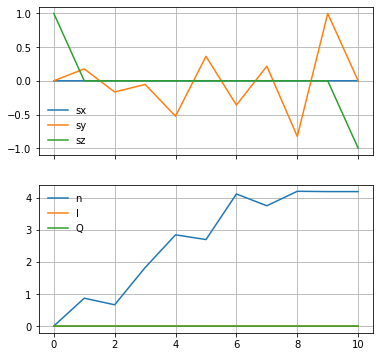

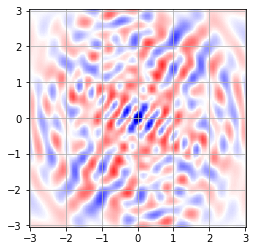

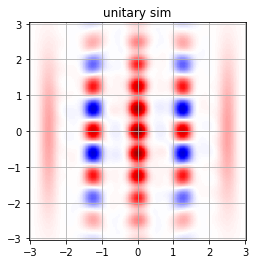

In [42]:
#Now, the unitary simulation
print('the circuit:')
print('betas: ' + str(betas))
print('phis deg: ' + str(180*phis/np.pi))
print('thetas deg: ' + str(180*thetas/np.pi))
N = 100
psi0 = qt.tensor(qt.basis(2,0),qt.basis(N,0))
#psit = qt.tensor(qt.basis(2,1),qt.basis(N,fock))
psis = unitary_circuit_sim(psi0, betas, phis, thetas, N)
psif = psis[-1]
plot_expect(psis)
g = qt.tensor(qt.basis(2,0), qt.identity(N))
e = qt.tensor(qt.basis(2,1), qt.identity(N))
psi_g = (g.dag()*psif).unit()
psi_e = (e.dag()*psif).unit()
xvec = np.linspace(-3,3,81)
plot_wigner(psi_g, xvec)
plot_wigner(psi_e, xvec, invert=False)
plt.title('unitary sim')

In [43]:
#Our cavity and qubit. When using pulse construction on the FPGA, these objects can be loaded, and 
#the pre-calibrated values can be used. Here, we are making a "FakeCavity" and a "FakeQubit" in order
#to demonstrate the pulse construction when not connected to the FPGA_lib.

#The following parameters are assumed to be defined under your cavity and qubit entity object in FPGA lib.
storage_params = {'chi_kHz': -191., 'chi_prime_Hz': -135., 'Ks_Hz': -81.5, 'epsilon_m_MHz': 0, 'unit_amp': 0.046384, 'sigma': 4, 'chop': 4}
qubit_params = {'unit_amp': 0.684312, 'sigma': 4, 'chop': 4}

#calculating epsilon m
wave = storage_params['unit_amp']*gaussian_wave(storage_params['sigma'], storage_params['chop'])
epsilon_m = 1/np.trapz(wave)
epsilon_m_MHz = 1e3*epsilon_m/2/np.pi
print('epsilon_m_MHz: %.6f' % epsilon_m_MHz)
storage_params['epsilon_m_MHz'] = epsilon_m_MHz

pi = rotate(np.pi, phi=0, sigma=qubit_params['sigma'], chop=qubit_params['chop'], dt=1)
Omega_m = np.real(np.max(pi))/qubit_params['unit_amp']

#creating the "Fake storage" and "Fake qubit"
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The alpha used during the ECD gates.
alpha_CD = 8
#Buffer time between R and ECD pulses.
buffer_time = 4

epsilon_m_MHz: 428.113770


In [44]:
#generating the conditional displacement circuit with all corrections.
cd_circuit_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,  buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)
cavity_dac_pulse, qubit_dac_pulse, = cd_circuit_dict['cavity_dac_pulse'], cd_circuit_dict['qubit_dac_pulse']

C:\ProgramData\Miniconda3\envs\opt3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


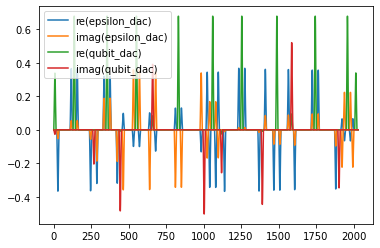

In [45]:
#plotting the pulse
plt.plot(np.real(cavity_dac_pulse), label='re(epsilon_dac)')
plt.plot(np.imag(cavity_dac_pulse), label='imag(epsilon_dac)')
plt.plot(np.real(qubit_dac_pulse), label='re(qubit_dac)')
plt.plot(np.imag(qubit_dac_pulse), label='imag(qubit_dac)')
plt.legend()

In [46]:
N = 100
N2 = 2
rho0 = qt.tensor(qt.basis(N2,0),qt.basis(N,0))
#rho0 = qt.tensor(qt.thermal_dm(N2, 0.05), qt.thermal_dm(N, 0.05))
chi = 2*np.pi*1e-6*storage_params['chi_kHz']
chi_prime = 2*np.pi*1e-9*storage_params['chi_prime_Hz']
Ks = 2*np.pi*1e-9*storage_params['Ks_Hz']
#delta_error = -2*np.pi*1e-9*5000
delta_error = 0
delta = -chi/2.0 + delta_error

#qubit_detune = 2*np.pi*1e-9*1e6
qubit_detune = 0
cavity_drive_scale = 1.0
qubit_drive_scale = 1.0
#vlad's anharmonicity
Kq = -2 * np.pi * 1e-3 * 2 * 200
kappa = 1/(550.0e3)
gamma_down_qubit = 1/(110.0e3)
#I know this is not quite correct but let's try it
T2E = 100.0e3
gamma_2 = 1/T2E
gamma_phi_qubit = gamma_2 - gamma_down_qubit/2.0
#
#doing master equation simulation
epsilon = cavity_drive_scale*2*np.pi*1e-3*storage_params['epsilon_m_MHz']*cavity_dac_pulse
Omega = qubit_drive_scale*Omega_m*qubit_dac_pulse
me_options = {'Kq':Kq, 'delta':delta, 'chi':chi,
    'chi_prime':chi_prime, 'Ks':Ks, 'kappa':0, 'gamma_down_qubit':0,
    'gamma_phi_qubit':0, 'output':True, 'qubit_detune':qubit_detune}
result, alpha = simulate_master_equation(epsilon = 1j*epsilon,rho0=rho0,Omega=1j*Omega, **me_options)

Solving for alpha(t)
Constructing Hamiltonian
Running mesolve:
10.0%. Run time:   0.32s. Est. time left: 00:00:00:02
20.0%. Run time:   0.61s. Est. time left: 00:00:00:02
30.0%. Run time:   0.93s. Est. time left: 00:00:00:02
40.0%. Run time:   1.24s. Est. time left: 00:00:00:01
50.0%. Run time:   1.56s. Est. time left: 00:00:00:01
60.0%. Run time:   1.89s. Est. time left: 00:00:00:01
70.0%. Run time:   2.36s. Est. time left: 00:00:00:01
80.0%. Run time:   2.91s. Est. time left: 00:00:00:00
90.0%. Run time:   3.26s. Est. time left: 00:00:00:00
Total run time:   3.59s


In [47]:
rhof = qt.ket2dm(result.states[-1])
#rhof = result.states[-1]
g = qt.tensor(qt.basis(N2,0), qt.identity(N))
e = qt.tensor(qt.basis(N2,1), qt.identity(N))
rhof_g = (g.dag()*rhof*g).unit()
rhof_e = (e.dag()*rhof*e).unit()
#correct final frame
D =  qt.displace(N,alpha[-1])
rhof_g =D*rhof_g*D.dag()
rhof_e =D*rhof_e*D.dag()

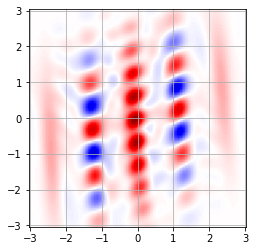

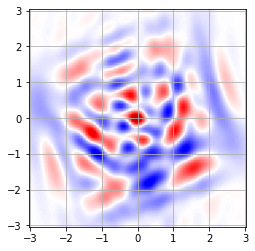

In [48]:
plot_wigner(rhof_g, xvec)
plot_wigner(-1*rhof_e, xvec)

In [49]:
fid_g = qt.fidelity(rhof_g, psi_e)**2
fid_e = qt.fidelity(rhof_e, psi_g)**2
print('fid g: %.6f fid e: %.6f' % (fid_g, fid_e))

fid g: 0.534105 fid e: 0.165719
